In [295]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [296]:
def f(x):
    return 3*x**2 - 4*x + 5

In [297]:
f(3.0)

20.0

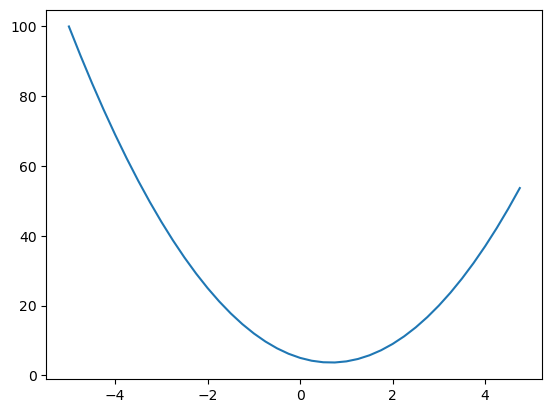

In [298]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [299]:
h = 0.00001
x = 2/3
(f(x+h) - f(x))/h

3.0000002482211127e-05

In [300]:
a = 2.0
b = -3.0
c = 10.0
d = a*b +c
print(d)

4.0


In [301]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0
d1 = a*b +c
a += h
d2 = a*b+c

print('d1', d1)
print('d2', d2)
print('slope', (d2-d1)/h)



d1 4.0
d2 3.999699999999999
slope -3.000000000010772


In [302]:
class Value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    
    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
      
    return out
  
  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out
  
  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    
    return out
  
  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')
    
    def _backward():
      self.grad += out.data * out.grad 
    out._backward = _backward
    
    return out
  
  
  def backward(self):
    
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

In [303]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
                    
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
    
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        
        dot.node(name= uid, label = "{%s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name= uid+ n._op, label = n._op)
            
            dot.edge(uid + n._op, uid)
            
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
        
    return dot


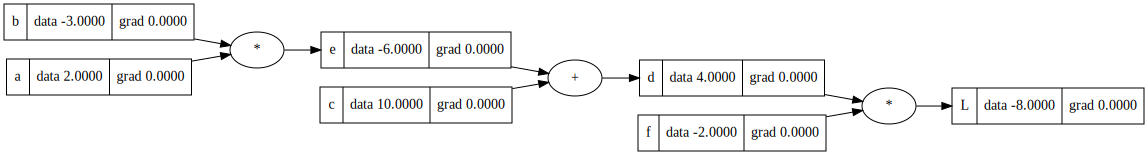

In [304]:
draw_dot(L)

In [305]:
f.grad = 4.0 


In [306]:
def lol():
    
    h = 0.001
    
    a = Value(2.0, label ='a')
    b = Value(-3.0, label ='b')
    c = Value(10.0, label='c')
    e = a*b; e.label='e'
    d = e+c; d.label='d'
    f = Value(-2.0, label='f')
    L = d*f; L.label ='L'
    L1 = L.data
    
    a = Value(2.0, label ='a')
    b = Value(-3.0, label ='b')
    c = Value(10.0, label='c')
    e = a*b; e.label='e'
    d = e+c; d.label='d'
    f = Value(-2.0, label='f')
    L = d*f; L.label ='L'
    L2 = L.data
    
    print((L2 -L1)/h)
    print((L2))
    print((L1))
    
lol()    

0.0
-8.0
-8.0


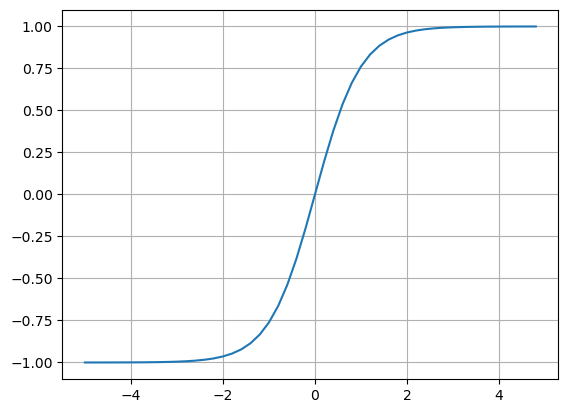

In [307]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid();

In [308]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'


In [309]:

o.backward()



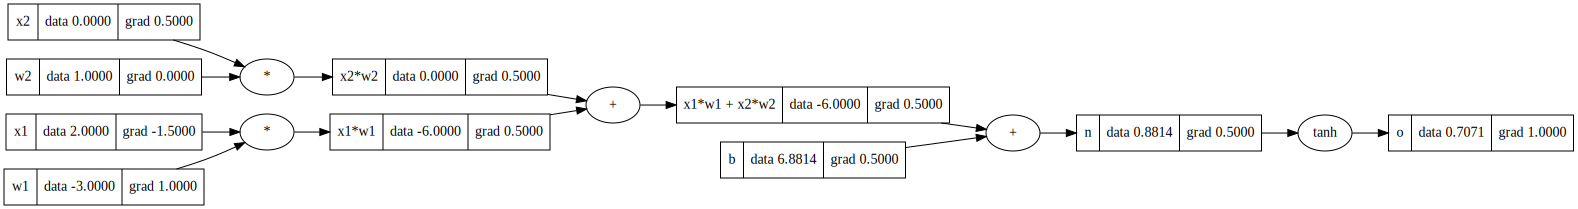

In [310]:
draw_dot(o)

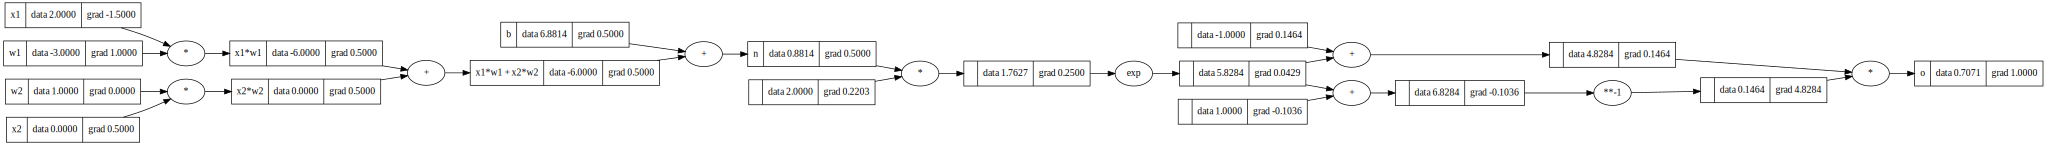

In [311]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# ----
e = (2*n).exp()
o = (e - 1) / (e + 1)
# ----
o.label = 'o'
o.backward()
draw_dot(o)

In [312]:
import torch

In [313]:
x1 = torch.Tensor([2.0]).double() ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double() ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double() ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad = True

b = torch.Tensor([6.8813735870195432]).double() ; b.requires_grad = True
n = x1*w1 + x2*w2 + b

o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())


0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [314]:
class Neuron:
    """
    A single neuron that computes a weighted sum of inputs and applies an activation function.
    """
    
    def __init__(self, nin):
        # Initialize neuron with random weights and bias
        self.w =  [Value(random.uniform(-1, 1)) for _ in range(nin)]  # List of weights, one for each input
        self.b = Value(random.uniform(-1, 1))  # Bias term
        
    def __call__(self, x):
        """
        Perform the forward pass for this neuron by calculating the weighted sum of inputs plus bias.
        Then, apply the tanh activation function to the result.
        """
        # Compute the weighted sum (w*x + b)
        act = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)  # Weighted sum + bias (activation function)
        out = act.tanh()  # Apply tanh activation
        return out
    
    def parameters(self):
        """
        Return the list of neuron parameters (weights and bias) for optimization.
        """
        return self.w + [self.b]  # Combine weights and bias into a single list


class Layer:
    """
    A layer in the neural network, consisting of multiple neurons.
    """
    
    def __init__(self, nin, nout):
        # Initialize the layer with a list of neurons
        self.neurons = [Neuron(nin) for _ in range(nout)]  # Create `nout` neurons, each taking `nin` inputs
        
    def __call__(self, x):
        """
        Perform the forward pass for the entire layer by passing the input through each neuron.
        """
        outs = [n(x) for n in self.neurons]  # Call each neuron with input `x` and get outputs
        return outs[0] if len(outs) == 1 else outs  # If there's only 1 output, return it directly; otherwise, return all
    
    def parameters(self):
        """
        Return all parameters (weights and biases) from all neurons in the layer.
        """
        return [p for neuron in self.neurons for p in neuron.parameters()]  # Collect parameters from all neurons


class MLP:
    """
    A Multi-Layer Perceptron (MLP), consisting of multiple layers of neurons.
    """
    
    def __init__(self, nin, nouts):
        """
        Initialize the MLP with the input size (`nin`) and a list of layer sizes (`nouts`).
        Each layer connects to the next, progressively reducing the size.
        """
        sz = [nin] + nouts  # Construct the layer sizes: input size + all subsequent layer sizes
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]  # Create layers according to sizes
    
    def __call__(self, x):
        """
        Perform the forward pass through all layers of the MLP.
        """
        for layer in self.layers:
            x = layer(x)  # Pass the input through each layer
        return x  # Return the final output
    
    def parameters(self):
        """
        Return all parameters (weights and biases) from all layers in the MLP.
        """
        return [p for layer in self.layers for p in layer.parameters()]  # Collect parameters from all layers
    
x = [2.0, 3.0, -1,0]
n = MLP(3, [4, 4, 1])
n(x)


Value(data=-0.9649585176744728)

In [315]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets
ypred = [n(x) for x in xs]
ypred

[Value(data=-0.9649585176744728),
 Value(data=-0.1854233586041497),
 Value(data=-0.5243021878334463),
 Value(data=-0.9816923885495792)]

In [316]:
for k in range(20):
  
  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
  
  # backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()
  
  # update
  for p in n.parameters():
    p.data += -0.1 * p.grad
  
  print(k, loss.data)

0 8.677990212224588
1 7.779540496225051
2 7.658596319743925
3 7.342621861100159
4 5.995951820560892
5 0.800231180577947
6 0.3912448312571788
7 0.24660720316562365
8 0.18185937479953415
9 0.14421679359688938
10 0.11912341868000764
11 0.10124846998205517
12 0.0878954876746985
13 0.07755694177618215
14 0.06932543972665993
15 0.06262285171729944
16 0.057063782106567866
17 0.052381660131783775
18 0.04838635848488625
19 0.04493870934253633


In [317]:
ypred

[Value(data=0.9117585301183847),
 Value(data=-0.9120451538627108),
 Value(data=-0.8753359711629836),
 Value(data=0.8822079065015074)]